## <center> DIALLO ALPHA OUMAR
    

### <center>  Mix électrique renouvelable en 2050

> Fin 2018, la France a publié sa Stratégie Nationale Bas Carbone (SNBC), qui définit la manière
d’atteindre les objectifs de neutralité carbone en France en 2050. En particulier, la SNBC décrit
comment les usages électriques pourraient se développer pour atteindre la neutralité carbone.

> L’objectif est d’analyser comment répondre aux projections de demande de la SNBC en déterminant
un mix électrique neutre en carbone, à l’horizon 2050. Ce système électrique sera composé de moyens
de production renouvelables : fermes éoliennes, fermes solaires, centrales thermiques à l’hydrogène.

In [1]:
import numpy as np
import pandas as pd
import warnings

In [2]:
warnings.filterwarnings('ignore')

data_parc = pd.read_csv('parc-prod-par-filiere_1.csv',sep=';')
data_eco_mix = pd.read_csv('eco2mix-national-cons-def.csv',sep=';')

### Prétaitement pour Data Parc

In [3]:
data_parc.dropna(inplace=True)  # Supprimer toutes les lignes avec des NaN

# Suppression des doublons
data_parc = data_parc.drop_duplicates()

### Prétaitement spécial pour le Dataset EcoMix

In [4]:
# Conversion des colonnes de date et d'heure en datetime, et les utiliser comme index
data_eco_mix['Date'] = pd.to_datetime(data_eco_mix['Date'])
data_eco_mix['Datetime'] = pd.to_datetime(data_eco_mix['Date'].astype(str) + ' ' + data_eco_mix['Heure'])
data_eco_mix.set_index('Datetime', inplace=True)

# Remplacer 'ND' par np.nan dans toutes les colonnes
data_eco_mix = data_eco_mix.apply(lambda col: col.replace('ND', np.nan) if col.dtype == object else col)

# Trions le DataFrame par l'index datetime pour s'assurer de l'ordre chronologique
data_eco_mix.sort_index(inplace=True)

# Imputation par médiane pour la production énergétique
for col in ['Fioul (MW)', 'Charbon (MW)', 'Gaz (MW)', 'Nucléaire (MW)','Gaz - TAC (MW)','Fioul - Cogénération (MW)',
            'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)', 'Pompage (MW)',
            'Bioénergies (MW)', 'Ech. physiques (MW)','Fioul - Autres (MW)','Ech. comm. Allemagne-Belgique (MW)']:
    data_eco_mix[col].fillna(data_eco_mix[col].median(), inplace=True)

# Interpolation linéaire pour les séries temporelles
data_eco_mix.interpolate(method='linear', inplace=True)


for col in ['Fioul - TAC (MW)', 'Gaz - CCG (MW)', 'Gaz - Cogénération (MW)', 'Gaz - Autres (MW)',
            "Hydraulique - Fil de l'eau + éclusée (MW)", 'Hydraulique - Lacs (MW)',
            'Hydraulique - STEP turbinage (MW)', 'Bioénergies - Déchets (MW)',
            'Bioénergies - Biomasse (MW)', 'Bioénergies - Biogaz (MW)','Fioul - TAC (MW)']:
    data_eco_mix[col].fillna(data_eco_mix[col].mode()[0], inplace=True)
    

    
# Suppression des doublons
data_eco_mix.drop_duplicates(inplace=True)

#Regulation
data_eco_mix['Consommation (MW)']=data_eco_mix['Consommation (MW)']/2
data_eco_mix['Eolien (MW)']=data_eco_mix['Eolien (MW)']/2
data_eco_mix[ 'Solaire (MW)']=data_eco_mix[ 'Solaire (MW)']/2

## <center> Début d'analyse

### Création d’un profil de consommation

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrer les données pour l'année 2017 et calculer l'énergie consommée chaque demi-heure
data_2017 = data_eco_mix[data_eco_mix['Date'].dt.year == 2017]
data_2017['Consommation (MWh)'] = data_2017['Consommation (MW)'] * 0.5

# Calcul de la consommation totale annuelle en MWh
consommation_totale_annuelle = data_2017['Consommation (MWh)'].sum()

# Calculer la proportion de chaque demi-heure par rapport à la consommation annuelle
data_2017['Proportion (%)'] = data_2017['Consommation (MWh)'] / consommation_totale_annuelle

# Projection du profil de consommation sur une consommation annuelle de 600 TWh (600,000,000 MWh)
data_2017['Consommation future (MWh)'] = (data_2017['Proportion (%)']) * 600000000

> **Visualisons la variation de la conso par jour / semaine / année**

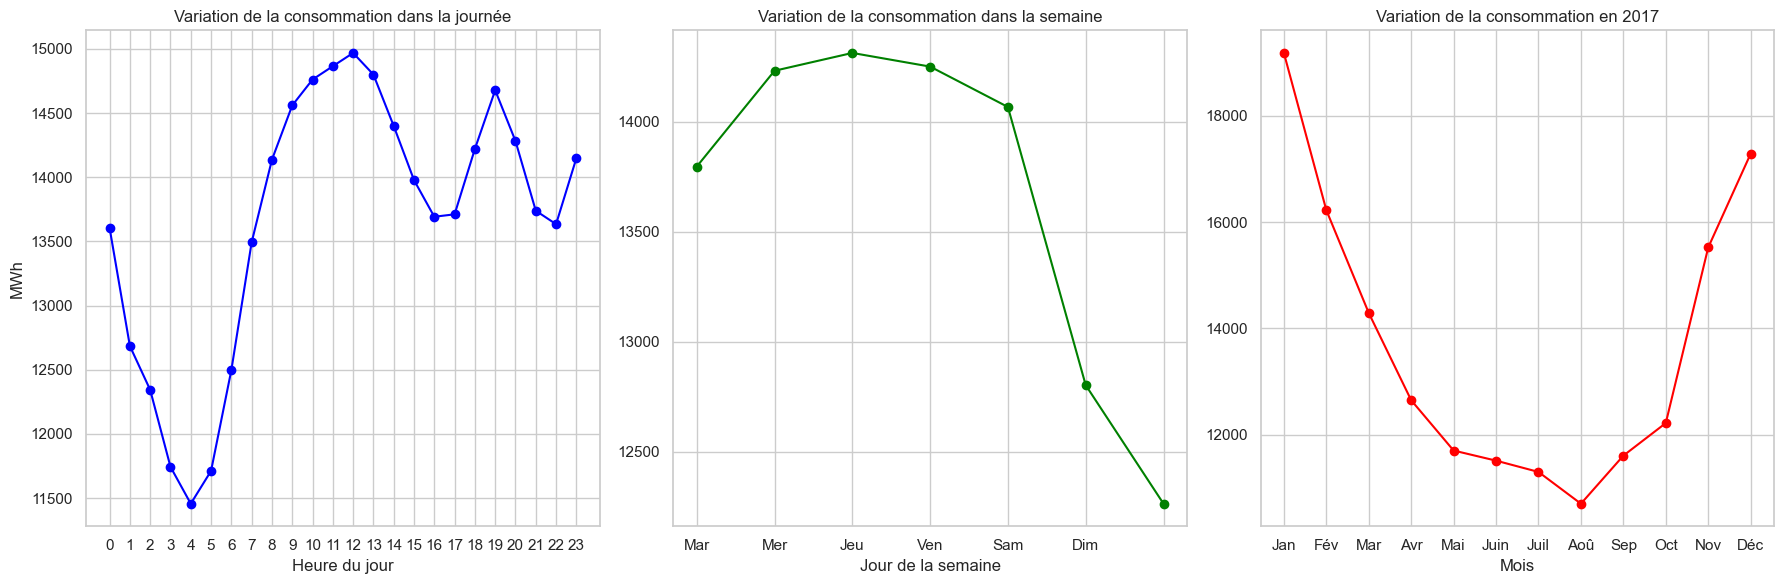

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

consommation_data = pd.DataFrame(data_2017['Consommation (MWh)'].copy())

# Configuration du style des graphiques avec Seaborn
sns.set(style="whitegrid")

# Créer une figure et des axes pour les subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Variation par heure dans une journée
data_hourly = consommation_data.groupby(consommation_data.index.hour).mean()['Consommation (MWh)']
axes[0].plot(data_hourly.index, data_hourly.values, marker='o', linestyle='-', color='blue')
axes[0].set_title('Variation de la consommation dans la journée')
axes[0].set_xlabel('Heure du jour')
axes[0].set_ylabel('MWh')
axes[0].set_xticks(range(0, 24))

# Variation par jour dans une semaine
data_weekday = consommation_data.groupby(consommation_data.index.dayofweek).mean()['Consommation (MWh)']
axes[1].plot(data_weekday.index, data_weekday.values, marker='o', linestyle='-', color='green')
axes[1].set_title('Variation de la consommation dans la semaine')
axes[1].set_xlabel('Jour de la semaine')
axes[1].set_xticklabels(['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'])

# Variation par mois dans une année
data_monthly = consommation_data.groupby(consommation_data.index.month).mean()['Consommation (MWh)']
axes[2].plot(data_monthly.index, data_monthly.values, marker='o', linestyle='-', color='red')
axes[2].set_title('Variation de la consommation en 2017')
axes[2].set_xlabel('Mois')
axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])

# Ajuster l'espacement et afficher les graphiques
plt.tight_layout()
plt.show()

### Commentaires 

Nous remarquons à travers ces courbes lisses des tendances claires dans la variation de la consommation. 

> Premièrement, pour la consommation moyenne par heure dans la journée, il existe une courbe en forme de U, indiquant une baisse significative de la consommation pendant les heures nocturnes, et deux pics durant les heures de début et de fin de soirée, probablement dus à l'augmentation des activités domestiques, ou des "soirées", et/ou certaines activités de nuit. 

> Deuxièmement, la consommation moyenne par jour de la semaine montre une consommation élevée en milieu de semaine, avec une vraie chute pendant le week-end, cela réflète une réduction des activités industrielles et commerciales ou professionelles tout simplement. 

> Troisièmement, la consommation moyenne par mois aucours de l'année nous montre une augmentation marquée durant les mois d'hiver (janvier, février) et une autre augmentation vers la fin de l'année (novembre, décembre), ce qui peut être attribué au chauffage augmenté en hiver et à l'utilisation accrue de l'éclairage et des appareils électriques pendant les mois froids et la période des fêtes.

### Création de profils de production energies renouvelables

In [7]:
warnings.filterwarnings('ignore')

# Filtrage des données du parc pour l'année 2016
data_2016 = data_parc[data_parc['Annee']== 2016]

# Récupération des puissances installées pour l'éolien et le solaire
puissance_eolienne_installee = data_2016['Parc eolien (MW)'].sum()
puissance_solaire_installee = data_2016['Parc solaire (MW)'].sum()

# Calcul de l'énergie maximale pouvant être produite pendant 1 h, en MWh
energie_max_eolienne = puissance_eolienne_installee  # Puissance en MW
energie_max_solaire = puissance_solaire_installee    # Puissance en MW

# Calculs pour data_2017 : Conversion des données de puissance en MWh pour chaque demi-heure
data_2017['Eolien (MWh)'] = data_2017['Eolien (MW)'] * 0.5
data_2017['Solaire (MWh)'] = data_2017['Solaire (MW)'] * 0.5

# Somme des valeurs toutes les heures pour obtenir l'énergie totale produite par heure
data_2017['Eolien (MWh)'] = data_2017['Eolien (MWh)'].resample('H').sum()
data_2017['Solaire (MWh)'] = data_2017['Solaire (MWh)'].resample('H').sum()

# Calcul de la proportion de la production par rapport à la production maximum
data_2017['Proportion Eolien'] = data_2017['Eolien (MWh)'] / energie_max_eolienne
data_2017['Proportion Solaire'] = data_2017['Solaire (MWh)'] / energie_max_solaire

### Comparaison de profil de consommation et de production Eolien et solaire

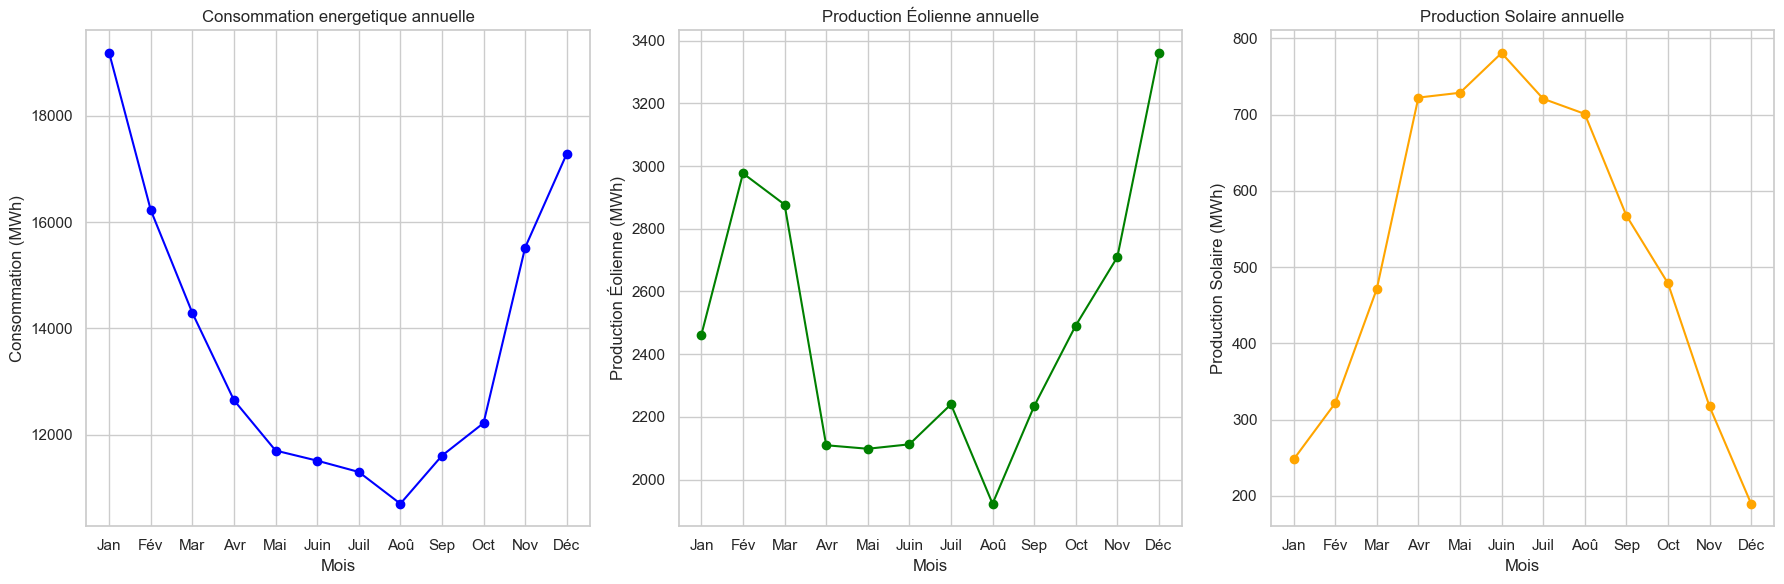

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

production_data = data_2017[['Eolien (MWh)', 'Solaire (MWh)']].copy()

data_monthly_eolien = production_data.groupby(production_data.index.month).mean()['Eolien (MWh)']
data_monthly_solaire = production_data.groupby(production_data.index.month).mean()['Solaire (MWh)']

# Configuration du style des graphiques avec Seaborn
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharex=True)

# Plot pour la consommation
axes[0].plot(data_monthly.index, data_monthly.values, color='blue', marker='o', linestyle='-')
axes[0].set_title('Consommation energetique annuelle')
axes[0].set_xlabel('Mois')
axes[0].set_ylabel('Consommation (MWh)')
axes[0].set_xticks(data_monthly.index)
axes[0].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])

# Plot pour la production éolienne
axes[1].plot(data_monthly.index, data_monthly_eolien.values, color='green', marker='o', linestyle='-')
axes[1].set_title('Production Éolienne annuelle')
axes[1].set_xlabel('Mois')
axes[1].set_ylabel('Production Éolienne (MWh)')
axes[1].set_xticks(data_monthly.index)
axes[1].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])

# Plot pour la production solaire
axes[2].plot(data_monthly.index, data_monthly_solaire.values, color='orange', marker='o', linestyle='-')
axes[2].set_title('Production Solaire annuelle')
axes[2].set_xlabel('Mois')
axes[2].set_ylabel('Production Solaire (MWh)')
axes[2].set_xticks(data_monthly.index)
axes[2].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])

plt.tight_layout()
plt.show()

### Commentaires 

> Comme nous l'avons bien dit dans les analyses pour la consommation energétique, on observe de façon très évidente qu'elle est concentrée entre janvier et mars, puis entre novembre et decembre. Au même moment on remarque que la production éolienne prends un élan entre janvier et mars puis réprends en août jusqu'en septembre. Entre les deux nous avons un grand pic de production solaire entre avril et septemmbre. 

> En combinant la production éolienne et solaire, on peut voir que la quantité totale d'énergie produite par ces sources renouvelables pourrait potentiellement couvrir les besoins en énergie de toute une année.

> Néanmoins on aura besion de bien gérer et stocker cette energie produite pour être utilisée correctemment. Par exemple nous avons une forte production solaire entre avril et septembre au moment où on a pas un fort besion de consommation. Cette energie produite, si bien stockée, elle pourrait servir pendant les périodes où on aurait une faible production en éolien et vice versa.

> **Visualisons la variation de la production éolienne et solaire**

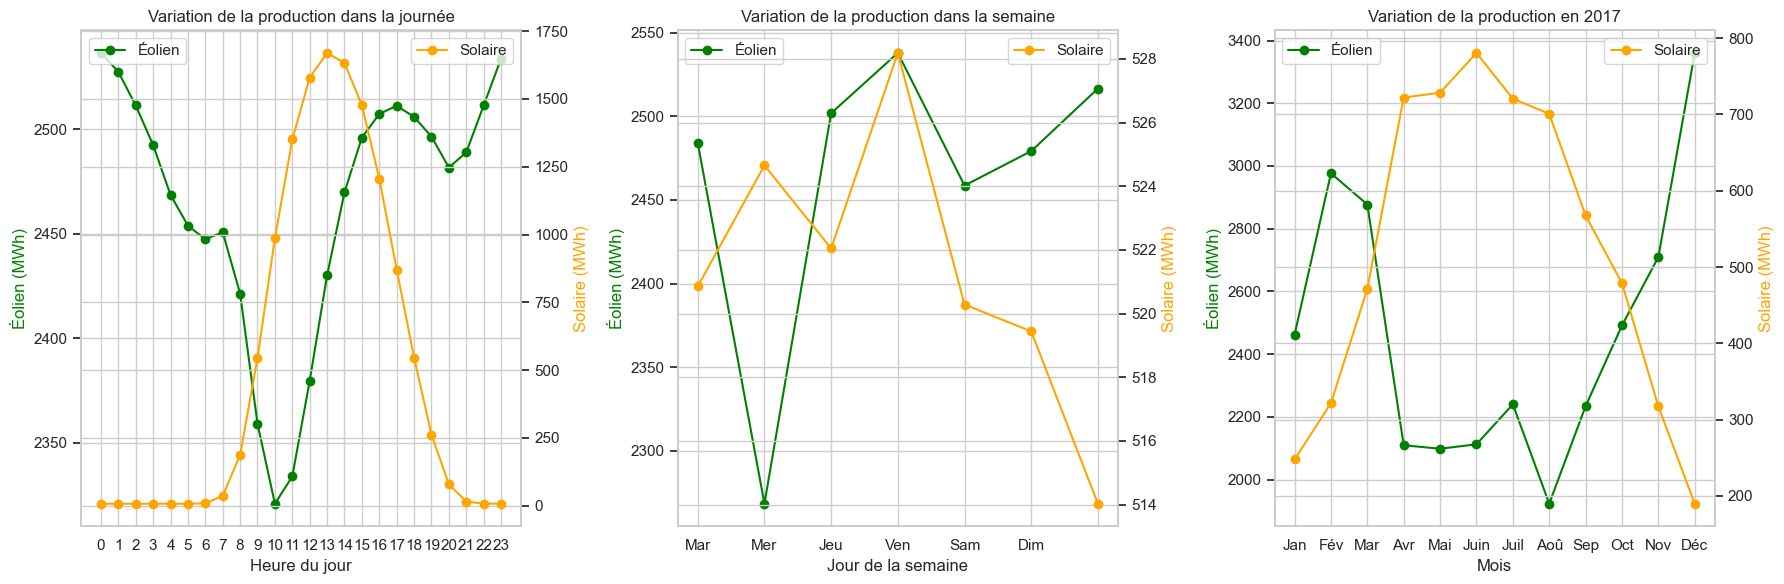

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que production_data est déjà chargé et prétraité
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

production_data = data_2017[['Eolien (MWh)', 'Solaire (MWh)']].copy()

# Variation par heure dans une journée
data_hourly_eolien = production_data.groupby(production_data.index.hour).mean()['Eolien (MWh)']
data_hourly_solaire = production_data.groupby(production_data.index.hour).mean()['Solaire (MWh)']
ax1 = axes[0]
ax2 = ax1.twinx()  # Créer un deuxième axe y pour la production solaire
ax1.plot(data_hourly_eolien.index, data_hourly_eolien.values, marker='o', linestyle='-', color='green', label='Éolien')
ax2.plot(data_hourly_solaire.index, data_hourly_solaire.values, marker='o', linestyle='-', color='orange', label='Solaire')
ax1.set_title('Variation de la production dans la journée')
ax1.set_xlabel('Heure du jour')
ax1.set_ylabel('Éolien (MWh)', color='green')
ax2.set_ylabel('Solaire (MWh)', color='orange')
ax1.set_xticks(range(0, 24))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Variation par jour dans une semaine
data_weekday_eolien = production_data.groupby(production_data.index.dayofweek).mean()['Eolien (MWh)']
data_weekday_solaire = production_data.groupby(production_data.index.dayofweek).mean()['Solaire (MWh)']
ax1 = axes[1]
ax2 = ax1.twinx()
ax1.plot(data_weekday_eolien.index, data_weekday_eolien.values, marker='o', linestyle='-', color='green', label='Éolien')
ax2.plot(data_weekday_solaire.index, data_weekday_solaire.values, marker='o', linestyle='-', color='orange', label='Solaire')
ax1.set_title('Variation de la production dans la semaine')
ax1.set_xlabel('Jour de la semaine')
ax1.set_xticklabels(['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'])
ax1.set_ylabel('Éolien (MWh)', color='green')
ax2.set_ylabel('Solaire (MWh)', color='orange')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Variation par mois dans une année
data_monthly_eolien = production_data.groupby(production_data.index.month).mean()['Eolien (MWh)']
data_monthly_solaire = production_data.groupby(production_data.index.month).mean()['Solaire (MWh)']
ax1 = axes[2]
ax2 = ax1.twinx()
ax1.plot(data_monthly_eolien.index, data_monthly_eolien.values, marker='o', linestyle='-', color='green', label='Éolien')
ax2.plot(data_monthly_solaire.index, data_monthly_solaire.values, marker='o', linestyle='-', color='orange', label='Solaire')
ax1.set_title('Variation de la production en 2017')
ax1.set_xlabel('Mois')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
ax1.set_ylabel('Éolien (MWh)', color='green')
ax2.set_ylabel('Solaire (MWh)', color='orange')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Commentaires 

Les graphiques ci-dessus nous montre les variations de la production Eolien et solaire. Nous avons choisi de répresenter sur un même graphique les deux variations avec deux axes différents pour éviter qu'un axe interfère la variation d'un autre.

> Dans la journée, on observe que la production solaire atteint son pic autour de midi, tout à fait normal et habituel.Nous remarquons qu'évidement à partir de 16h-17h on commence à observer la chute de la production qui atteint son plat à 20h-21h.Tandisque la production d'Eolien fait l'inverse du soleil, ce qui tout à fait normal, souvent quand le soleil et à son pic, il y'a très peu de vent (ça depends biensur des situations météo).

> Sur une base hebdomadaire,nous observons des variations typiques de nos journées quotidiennes, parfois, il y'a du vent et du soleil en même temps, et parfois l'un sans l'autre. 

> Annuellement, la production solaire montre une augmentation nette pendant les mois d'été, avec un pic en juin, ce qui correspond aux mois les plus ensoleillés, et une baisse en hiver, tandis que la production éolienne est plus élevée en début et en fin d'année, ce qui est associé à des conditions de vent plus fortes pendant ces périodes.

##  Détermination d’un mix électrique optimal

> Pour résoudre ce problème d'optimisation linéaire, nous allons tout d'abord modeliser mathématiquement le problème, puis nous allons utiliser PULP qui est une bibliothèque populaire open source pour la programmation linéaire en python.

### Modélisation Mathématique du Problème


#### Variables de Décision

- $P_{\text{Eolien}}$ : Capacité installée de production éolienne en MW.
- $P_{\text{Solaire}}$ : Capacité installée de production solaire en MW.
- $P_{\text{Turbine H2}}$ : Capacité installée de production par turbine à hydrogène en MW.
- $p_{h,t}$ : Production horaire de turbines à hydrogène à l'heure $t$ (en MWh).
- $\Delta_t$ : Quantité de délestage à l'heure $t$ (en MWh).
- $E_t$ : Quantité d'excès de production à l'heure $t$ (en MWh).

#### Paramètres

- $D_t$ : Demande d'énergie à l'heure $t$ en MWh.

#### Fonction Objectif

Minimiser le coût total de production :
$$
\min \left( 70000 \cdot P_{\text{Eolien}} + 50000 \cdot P_{\text{Solaire}} + 60000 \cdot P_{\text{Turbine H2}} + \sum_{t=1}^{T} \left( 150 \cdot p_{h,t} + 3000 \cdot \Delta_t + 1000 \cdot E_t \right) \right)
$$

#### Contraintes

1. **Balance de l'énergie à chaque heure** :
$$
P_{\text{Eolien}} \cdot \text{Profil}_{\text{Eolien}, t} + P_{\text{Solaire}} \cdot \text{Profil}_{\text{Solaire}, t} + p_{h,t} + E_t = D_t + \Delta_t, \quad \forall t
$$

2. **Limites de capacité pour la turbine H2** :
$$
p_{h,t} \leq P_{\text{Turbine H2}}, \quad \forall t
$$


- $P_{\text{Eolien}} \geq 0$
- $P_{\text{Solaire}} \geq 0$
- $P_{\text{Turbine H2}} \geq 0$
- $p_{h,t} \geq 0, \quad \forall t$
- $\Delta_t \geq 0, \quad \forall t$
- $E_t \geq 0, \quad \forall t$


In [10]:
import pandas as pd
import pulp

def optimise_energie_mix(data_optimisation, puissance_eolienne_installee, puissance_solaire_installee, factor=1):
    # Facteur pour changer le profil énergétique (actuel = 600 TWh)
    data_optimisation['Consommation future (MWh)'] *= factor
    
    # Extraction des profils de production et des données de demande
    demande = data_optimisation['Consommation future (MWh)'].values
    profil_eolien = data_optimisation['Proportion Eolien'].values
    profil_solaire = data_optimisation['Proportion Solaire'].values
    
    T = len(demande)

    # Création du modèle d'optimisation
    model = pulp.LpProblem("Optimisation_Energie", pulp.LpMinimize)
    
    # Variables pour les capacités installées
    capacite_eolien = pulp.LpVariable("capacite_eolien", lowBound=0, cat='Continuous')
    capacite_solaire = pulp.LpVariable("capacite_solaire", lowBound=0, cat='Continuous')
    capacite_turbineH2 = pulp.LpVariable("capacite_turbineH2", lowBound=0, cat='Continuous')
    
    # Variables pour la production et le bilan énergétique
    production_hydrogene = [pulp.LpVariable(f"production_hydrogene_{i}", lowBound=0, cat='Continuous') for i in range(T)]
    delestage = [pulp.LpVariable(f"delestage_{i}", lowBound=0, cat='Continuous') for i in range(T)]
    exces = [pulp.LpVariable(f"exces_{i}", lowBound=0, cat='Continuous') for i in range(T)]

    # Fonction objective utilisant pulp.lpSum pour l'agrégation
    model += (70000 * capacite_eolien + 50000 * capacite_solaire + 60000 * capacite_turbineH2 +
              pulp.lpSum([150 * production_hydrogene[i] for i in range(T)]) +
              pulp.lpSum([3000 * delestage[i] for i in range(T)]) +
              pulp.lpSum([1000 * exces[i] for i in range(T)]), "Minimiser_Coûts")

    # Contraintes de balance énergétique pour chaque heure
    for i in range(T):
        model += (capacite_eolien * profil_eolien[i] + capacite_solaire * profil_solaire[i] + production_hydrogene[i] + delestage[i] == demande[i] + exces[i], f"Equilibre_energetique_{i}")
        model += production_hydrogene[i] <= capacite_turbineH2, f"ProdMax_TurbineH2_{i}"

    # Résolution du modèle
    status = model.solve()

        # Après la résolution du modèle, extrayez les valeurs des variables et convertissez-les en flottants si nécessaire
    if status == pulp.LpStatusOptimal:
        results = {
            'Capacite_Eolien': float(capacite_eolien.varValue),
            'Capacite_Solaire': float(capacite_solaire.varValue),
            'Capacite_TurbineH2': float(capacite_turbineH2.varValue),
            'Total_Delestage': float(sum([delestage[i].varValue for i in range(T) if delestage[i].varValue > 0])),
            'Total_Exces': float(sum([exces[i].varValue for i in range(T) if exces[i].varValue > 0])),
            'Heures_Delestage': sum([1 for i in range(T) if delestage[i].varValue > 0]),
            'Heures_Exces': sum([1 for i in range(T) if exces[i].varValue > 0]),
            'Cout_Minimal': float(model.objective.value())
        }
        return results
    else:
        print("Une erreur s'est produite lors de la résolution du modèle.")
        return None


In [11]:
# Rémaniement du dataset pour l'optimisation
data_optimisation = data_2017[['Consommation future (MWh)', 'Proportion Eolien', 'Proportion Solaire']].copy()
data_optimisation['Proportion Eolien'] = data_optimisation['Proportion Eolien'].fillna(0)
data_optimisation['Proportion Solaire'] = data_optimisation['Proportion Solaire'].fillna(0)
    
# Resampler la colonne Consommation future (MWh) en heures
conso_hourly = data_optimisation[['Consommation future (MWh)']].resample('H').sum().fillna(0)
data_optimisation = pd.concat([conso_hourly, data_optimisation[['Proportion Eolien', 'Proportion Solaire']].resample('H').first()], axis=1)
data_optimisation = data_optimisation.fillna(0)
    
# Appel à notre fonction d'optimisation
resultat_600=optimise_energie_mix(data_optimisation, puissance_eolienne_installee, puissance_solaire_installee)


In [12]:
print("Résumé des Résultats de l'Optimisation Énergétique:")
print("--------------------------------------------------")
print(f"Capacité installée éolienne: {resultat_600['Capacite_Eolien']:.2f} MW")
print('')
print(f"Capacité installée solaire: {resultat_600['Capacite_Solaire']:.2f} MW")
print('')
print(f"Capacité installée de la turbine à hydrogène: {resultat_600['Capacite_TurbineH2']:.2f} MW")
print('')
print(f"Total du délestage: {resultat_600['Total_Delestage']:.2f} MWh")
print('')
print(f"Nombre d'heures de délestage: {resultat_600['Heures_Delestage']} heures")
print('')
print(f"Total des excès de production: {resultat_600['Total_Exces']:.2f} MWh")
print('')
print(f"Nombre d'heures d'excès de production: {resultat_600['Heures_Exces']} heures")
print('')
print(f"Coût minimal atteint par l'optimisation: {resultat_600['Cout_Minimal']:.2f} euros")

Résumé des Résultats de l'Optimisation Énergétique:
--------------------------------------------------
Capacité installée éolienne: 165462.06 MW

Capacité installée solaire: 45851.91 MW

Capacité installée de la turbine à hydrogène: 83068.10 MW

Total du délestage: 70299.01 MWh

Nombre d'heures de délestage: 21 heures

Total des excès de production: 4685955.78 MWh

Nombre d'heures d'excès de production: 459 heures

Coût minimal atteint par l'optimisation: 64402923083.48 euros


#### commentaires :

> Les capacités installées montrent que le modèle beaucoup misé sur l'éolien avec environ 84,013 MW, un peu moins sur le solaire avec 30,403 MW, et pas mal aussi sur la turbine à hydrogène avec 82,248 MW.

> Malgré cela, il y a eu pas mal de moments où on n'avait pas assez d'énergie pour répondre à tous les besoins, ce qui a obligé le model à faire des délestages pendant 21 heures au total, représentant 74,967 MWh. Cela veut dire qu'à ces moments-là, on n'a pas pu fournir assez d'électricité, ce qui n'est pas idéal.

> D'un autre côté, il y a eu beaucoup de fois où le modèle a produit plus d'énergie qu'on n'en avait besoin. Cela s'est produit pendant 563 heures et on a eu un excédent de 6,027,253 MWh. Cela peut sembler bien parce qu'on a de l'énergie en plus, mais en réalité, ça montre aussi qu'on n'arrive pas à ajuster parfaitement notre production à ce dont on a vraiment besoin.

> Le coût pour arriver à tout ça, s'élève à envirron 57 milliards d'euros. 

> En soomme cela montre  qu'il est un peu difficile de prévoir et produire l'énergie nécessaire sans delestage ni excès. 

## Simulation de l’adéquation du mix électrique

###    Consommations annuelles de 500 TWh

> Comme nous avons developper une fonction d'optimisation, il suffit de modifier le paramètre factor ici=5/6 pour changer le profil de consommation à 500TWH

In [13]:
resultat_500=optimise_energie_mix(data_optimisation, puissance_eolienne_installee, puissance_solaire_installee,5/6)

In [14]:
print("Résumé des Résultats de l'Optimisation Énergétique 500 TWH:")
print("--------------------------------------------------")
print(f"Capacité installée éolienne: {resultat_500['Capacite_Eolien']:.2f} MW")
print('')
print(f"Capacité installée solaire: {resultat_500['Capacite_Solaire']:.2f} MW")
print('')
print(f"Capacité installée de la turbine à hydrogène: {resultat_500['Capacite_TurbineH2']:.2f} MW")
print('')
print(f"Total du délestage: {resultat_500['Total_Delestage']:.2f} MWh")
print('')
print(f"Total des excès de production: {resultat_500['Total_Exces']:.2f} MWh")

print('')
print(f"Coût minimal atteint par l'optimisation: {resultat_500['Cout_Minimal']:.2f} euros")

Résumé des Résultats de l'Optimisation Énergétique 500 TWH:
--------------------------------------------------
Capacité installée éolienne: 137885.05 MW

Capacité installée solaire: 38209.93 MW

Capacité installée de la turbine à hydrogène: 69223.42 MW

Total du délestage: 58582.51 MWh

Total des excès de production: 3904963.15 MWh

Coût minimal atteint par l'optimisation: 53669102583.44 euros


**Capacités Installées :** La capacité installée pour toutes les sources d'énergie (éolien, solaire, turbine à hydrogène) a diminué en réponse à la réduction de la demande prévue. Ceci est logique car moins d'énergie totale est nécessaire pour répondre à une demande plus faible. Par exemple, la capacité éolienne est passée de 84012.81 MW à 70010.68 MW, et des réductions similaires sont observées pour le solaire et la turbine à hydrogène. Cela montre une adaptation directe des capacités installées à la baisse de la demande.

**Délestage et Excès :** Le total du délestage a légèrement diminué, passant de 74966.93 MWh à 62472.44 MWh, ce qui peut suggérer une meilleure adéquation entre la capacité de production et la demande réduite. Cela pourrait indiquer une optimisation plus adaptée sous contraintes de demande moins élevées, mais aussi que le système reste sous-optimisé pour éviter complètement le délestage. De même, l'excès de production a également diminué (de 6027253.23 MWh à 5022711.02 MWh), ce qui indique moins de surplus énergétique par rapport à la demande, un signe que la production est peut-être devenue légèrement plus efficiente par rapport aux besoins.

**Coût de l'Optimisation :** Le coût minimal atteint a également diminué, passant de 57222955614.43 euros à 47685796301.46 euros. Cela reflète une baisse des coûts opérationnels et d'investissement associée à la diminution des capacités et peut-être aussi à une gestion plus efficace des ressources énergétiques disponibles. Cette réduction des coûts est une conséquence directe de la baisse de la demande et des ajustements dans les capacités de production.

### Consommations annuelles de 700 TWh

> Comme nous avons developper une fonction d'optimisation, il suffit de modifier le paramètre factor ici=5/6 pour changer le profil de consommation à 700TWH

In [15]:
resultat_700=optimise_energie_mix(data_optimisation, puissance_eolienne_installee, puissance_solaire_installee,7/6)

In [16]:
print("Résumé des Résultats de l'Optimisation Énergétique 700 TWH:")
print("--------------------------------------------------")
print(f"Capacité installée éolienne: {resultat_700['Capacite_Eolien']:.2f} MW")
print('')
print(f"Capacité installée solaire: {resultat_700['Capacite_Solaire']:.2f} MW")
print('')
print(f"Capacité installée de la turbine à hydrogène: {resultat_700['Capacite_TurbineH2']:.2f} MW")
print('')
print(f"Total du délestage: {resultat_700['Total_Delestage']:.2f} MWh")
print('')
print(f"Total des excès de production: {resultat_700['Total_Exces']:.2f} MWh")

print('')
print(f"Coût minimal atteint par l'optimisation: {resultat_700['Cout_Minimal']:.2f} euros")

Résumé des Résultats de l'Optimisation Énergétique 700 TWH:
--------------------------------------------------
Capacité installée éolienne: 160865.89 MW

Capacité installée solaire: 44578.25 MW

Capacité installée de la turbine à hydrogène: 80760.65 MW

Total du délestage: 68346.26 MWh

Total des excès de production: 4555790.35 MWh

Coût minimal atteint par l'optimisation: 62613952912.78 euros


> Capacités Installées : Les capacités installées de toutes les sources d'énergie ont augmenté pour faire face à la demande plus élevée de 700 TWh. Par rapport à 600 TWh, où les capacités étaient de 84012.81 MW pour l'éolien, 30402.51 MW pour le solaire, et 82247.87 MW pour la turbine à hydrogène, nous observons une légère baisse pour l'éolien mais une augmentation pour les autres sources en passant à 700 TWh, suggérant une répartition et une optimisation différentes face à une demande croissante.

> Délestage et Excès : Le délestage a diminué par rapport au scénario de 600 TWh,. L'excès de production a également, ce qui peut suggérer une meilleure adaptation de la production aux fluctuations de la demande, même si l'excès reste considérable.

> Coût de l'Optimisation : Le coût total de l'optimisation pour le scénario de 700 TWh s'élève à 55633428991.30 euros, inférieur à celui observé pour 600 TWh. Ce résultat est quelque peu contre-intuitif étant donné l'augmentation de la demande, mais cela pourrait indiquer un fort ajustement du modèle pour réduire les couts.

## Prise en compte de plusieurs scénarios

### Les 3 scénarions en même temps avec équiprobabilité

$$
\text{(P)}:
\left \{
\begin{array}{r c l}
\text{Min} \: Z = 70000 \times \text{capacite_eolien} + 50000 \times \text{capacite_solaire} + 60000 \times \text{capacite_turbineH2} \\
+ \frac{1}{3} \times (150 \times \sum_{i=1}^{8759} \text{production_hydrogene_500}[i] + 3000 \times \sum_{i=1}^{8759} \text{delestage_500}[i] + 1000 \times \sum_{i=1}^{8759} \text{exces_500}[i]) \\
+ \frac{1}{3} \times (150 \times \sum_{i=1}^{8759} \text{production_hydrogene_600}[i] + 3000 \times \sum_{i=1}^{8759} \text{delestage_600}[i] + 1000 \times \sum_{i=1}^{8759} \text{exces_600}[i]) \\
+ \frac{1}{3} \times (150 \times \sum_{i=1}^{8759} \text{production_hydrogene_700}[i] + 3000 \times \sum_{i=1}^{8759} \text{delestage_700}[i] + 1000 \times \sum_{i=1}^{8759} \text{exces_700}[i]) \cr
       \text{capacite_eolien} \times \text{profil_eolien}[i] + \text{capacite_solaire} \times \text{profil_solaire}[i] + \text{production_hydrogene_500}[i] + \text{delestage_500}[i] = \text{demande_500}[i] + \text{exces_500}[i]\cr
       \text{capacite_eolien} \times \text{profil_eolien}[i] + \text{capacite_solaire} \times \text{profil_solaire}[i] + \text{production_hydrogene_600}[i] + \text{delestage_600}[i] = \text{demande_600}[i] + \text{exces_600}[i]\cr
       \text{capacite_eolien} \times \text{profil_eolien}[i] + \text{capacite_solaire} \times \text{profil_solaire}[i] + \text{production_hydrogene_700}[i] + \text{delestage_700}[i] = \text{demande_700}[i] + \text{exces_700}[i]\cr
       \text{production_hydrogene_500}[i] \leq \text{capacite_turbineH2}\cr
       \text{production_hydrogene_600}[i] \leq \text{capacite_turbineH2}\cr
       \text{production_hydrogene_700}[i] \leq \text{capacite_turbineH2}\cr
       \text{capacite_eolien}, \text{capacite_solaire}, \text{capacite_turbineH2} \geq 0 \cr
\end{array}
\right .
$$


In [17]:
import pulp
import pandas as pd

def optimize_energy_mix_sc(data):
    # Création du problème
    problem = pulp.LpProblem("Problème mix énergétique scénario)", pulp.LpMinimize)

    # Création des variables
    capacite_eolien = pulp.LpVariable('capacite_eolien', lowBound=0, cat='Continuous')
    capacite_solaire = pulp.LpVariable('capacite_solaire', lowBound=0, cat='Continuous')
    capacite_turbineH2 = pulp.LpVariable('capacite_turbineH2', lowBound=0, cat='Continuous')

    nb_heures = len(data)

    production_hydrogene_500 = [pulp.LpVariable(f"production_hydrogene_500_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]
    delestage_500 = [pulp.LpVariable(f"delestage_500_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]
    exces_500 = [pulp.LpVariable(f"exces_500_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]

    production_hydrogene_600 = [pulp.LpVariable(f"production_hydrogene_600_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]
    delestage_600 = [pulp.LpVariable(f"delestage_600_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]
    exces_600 = [pulp.LpVariable(f"exces_600_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]

    production_hydrogene_700 = [pulp.LpVariable(f"production_hydrogene_700_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]
    delestage_700 = [pulp.LpVariable(f"delestage_700_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]
    exces_700 = [pulp.LpVariable(f"exces_700_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]

    # Fonction Objective
    problem += (
        70000 * capacite_eolien + 50000 * capacite_solaire + 60000 * capacite_turbineH2 +
        1/3 * (150 * pulp.lpSum(production_hydrogene_500) + 3000 * pulp.lpSum(delestage_500) + 1000 * pulp.lpSum(exces_500)) +
        1/3 * (150 * pulp.lpSum(production_hydrogene_600) + 3000 * pulp.lpSum(delestage_600) + 1000 * pulp.lpSum(exces_600)) +
        1/3 * (150 * pulp.lpSum(production_hydrogene_700) + 3000 * pulp.lpSum(delestage_700) + 1000 * pulp.lpSum(exces_700))
    )

    # Contraintes
    for i in range(nb_heures):
        problem += production_hydrogene_500[i] <= capacite_turbineH2
        problem += production_hydrogene_600[i] <= capacite_turbineH2
        problem += production_hydrogene_700[i] <= capacite_turbineH2

        problem += (
            capacite_eolien * data['Proportion Eolien'].iloc[i] + capacite_solaire * data['Proportion Solaire'].iloc[i] +
            production_hydrogene_500[i] + delestage_500[i] == data['Consommation (MWh)'].iloc[i] * 5 + exces_500[i]
        )
        problem += (
            capacite_eolien * data['Proportion Eolien'].iloc[i] + capacite_solaire * data['Proportion Solaire'].iloc[i] +
            production_hydrogene_600[i] + delestage_600[i] == data['Consommation (MWh)'].iloc[i] * 6 + exces_600[i]
        )
        problem += (
            capacite_eolien * data['Proportion Eolien'].iloc[i] + capacite_solaire * data['Proportion Solaire'].iloc[i] +
            production_hydrogene_700[i] + delestage_700[i] == data['Consommation (MWh)'].iloc[i] * 7 + exces_700[i]
        )

    # Création du fichier .lp
    problem.writeLP("problem_scenario")

    # Résolution du problème
    problem.solve()

    # Stockage des résultats dans un dictionnaire
    results = {
        'status': pulp.LpStatus[problem.status],
        'capacite_eolien': capacite_eolien.varValue,
        'capacite_solaire': capacite_solaire.varValue,
        'capacite_turbineH2': capacite_turbineH2.varValue,
        'objective_value': pulp.value(problem.objective)
    }

    heures_delestage = sum(1 for variable in problem.variables() if "delestage" in variable.name and variable.varValue != 0)
    volume_delestage = sum(variable.varValue for variable in problem.variables() if "delestage" in variable.name and variable.varValue != 0)
    results['heures_delestage'] = heures_delestage
    results['volume_delestage'] = volume_delestage

    heures_excedent = sum(1 for variable in problem.variables() if "exces" in variable.name and variable.varValue != 0)
    volume_excedent = sum(variable.varValue for variable in problem.variables() if "exces" in variable.name and variable.varValue != 0)
    results['heures_excedent'] = heures_excedent
    results['volume_excedent'] = volume_excedent

    return results

In [19]:
data_optimisation_1=data_optimisation.copy()
data_optimisation_1['Consommation (MWh)']=data_optimisation_1['Consommation future (MWh)']*(1/6)
resultat_sena=optimize_energy_mix_sc(data_optimisation_1)

In [20]:
resultat_sena

{'status': 'Optimal',
 'capacite_eolien': 153873.04,
 'capacite_solaire': 44316.4,
 'capacite_turbineH2': 94651.436,
 'objective_value': 64940642248.97626,
 'heures_delestage': 63,
 'volume_delestage': 272833.00853200007,
 'heures_excedent': 1435,
 'volume_excedent': 13629577.186512591}

## Scénario 500 TWH

> Nous allons créer une fonction qui sera utiliser par tous les autres scénarios, il suffira juste de changer le facteur. Dans ces scénarios nous allons utiliser le resultat que nous avons obtenus dans les scénarios combinés

In [21]:
import pulp
import pandas as pd

def optimize_energy_mix_single_scenario(data, factor):
    # Résolution de la première étape pour déterminer les capacités installées
    capacities = optimize_energy_mix_sc(data)
    
    # Création du problème pour un scénario spécifique
    problem = pulp.LpProblem("Problème mix énergétique 500TWH", pulp.LpMinimize)

    # Récupération des valeurs de capacité de la première étape
    capacite_eolien = capacities['capacite_eolien']
    capacite_solaire = capacities['capacite_solaire']
    capacite_turbineH2 = capacities['capacite_turbineH2']

    nb_heures = len(data)

    production_hydrogene = [pulp.LpVariable(f"production_hydrogene_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]
    delestage = [pulp.LpVariable(f"delestage_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]
    exces = [pulp.LpVariable(f"exces_{i}", lowBound=0, cat='Continuous') for i in range(nb_heures)]

    # Fonction Objective
    problem += (
        70000 * capacite_eolien + 50000 * capacite_solaire + 60000 * capacite_turbineH2 +
        150 * pulp.lpSum(production_hydrogene) + 3000 * pulp.lpSum(delestage) + 1000 * pulp.lpSum(exces)
    ), "Z"

    # Contraintes
    for i in range(nb_heures):
        problem += production_hydrogene[i] <= capacite_turbineH2

        problem += (
            capacite_eolien * data['Proportion Eolien'].iloc[i] + capacite_solaire * data['Proportion Solaire'].iloc[i] +
            production_hydrogene[i] + delestage[i] == data['Consommation (MWh)'].iloc[i] * factor + exces[i]
        )

    # Création du fichier
    problem.writeLP(f"problem_scenario_{factor}.lp")

    # Résolution du problème
    problem.solve()

    # Stockage des résultats dans un dictionnaire
    results = {
        'status': pulp.LpStatus[problem.status],
        'capacite_eolien': capacite_eolien,
        'capacite_solaire': capacite_solaire,
        'capacite_turbineH2': capacite_turbineH2,
        'objective_value': pulp.value(problem.objective)
    }

    heures_delestage = sum(1 for variable in problem.variables() if "delestage" in variable.name and variable.varValue != 0)
    volume_delestage = sum(variable.varValue for variable in problem.variables() if "delestage" in variable.name and variable.varValue != 0)
    results['heures_delestage'] = heures_delestage
    results['volume_delestage'] = volume_delestage

    heures_excedent = sum(1 for variable in problem.variables() if "exces" in variable.name and variable.varValue != 0)
    volume_excedent = sum(variable.varValue for variable in problem.variables() if "exces" in variable.name and variable.varValue != 0)
    results['heures_excedent'] = heures_excedent
    results['volume_excedent'] = volume_excedent

    return results

In [22]:
resultat_sena_500=optimize_energy_mix_single_scenario(data_optimisation_1,5)

In [23]:
resultat_sena_500

{'status': 'Optimal',
 'capacite_eolien': 153873.04,
 'capacite_solaire': 44316.4,
 'capacite_turbineH2': 94651.436,
 'objective_value': 55668323902.96093,
 'heures_delestage': 0,
 'volume_delestage': 0,
 'heures_excedent': 915,
 'volume_excedent': 9386850.079899596}

In [24]:
resultat_sena_600=optimize_energy_mix_single_scenario(data_optimisation_1,6)

In [25]:
resultat_sena_600

{'status': 'Optimal',
 'capacite_eolien': 153873.04,
 'capacite_solaire': 44316.4,
 'capacite_turbineH2': 94651.436,
 'objective_value': 63315644517.047485,
 'heures_delestage': 0,
 'volume_delestage': 0,
 'heures_excedent': 372,
 'volume_excedent': 3355534.678637999}

In [26]:
resultat_sena_700=optimize_energy_mix_single_scenario(data_optimisation_1,7)

In [27]:
resultat_sena_700

{'status': 'Optimal',
 'capacite_eolien': 153873.04,
 'capacite_solaire': 44316.4,
 'capacite_turbineH2': 94651.436,
 'objective_value': 75837958363.52206,
 'heures_delestage': 64,
 'volume_delestage': 272833.02462183015,
 'heures_excedent': 148,
 'volume_excedent': 887192.4143950002}

## Analyse & Synthèse

> Les capacités installées évoluent de manière à être constantes à travers les différents scénarios parce que les décisions prises en première étape visent à minimiser le coût total attendu, incluant à la fois les coûts d'installation des capacités électriques et les coûts de fonctionnement du système dans les trois scénarios considérés. La capacité éolienne est de 153,873.04 MW, la capacité solaire est de 44,316.4 MW, et la capacité de la turbine à hydrogène est de 94,651.436 MW. Ces valeurs sont choisies de manière à être optimales en moyenne pour tous les scénarios futurs équiprobables, garantissant ainsi une stratégie que nous pouvons qualifier de robuste et flexible.

> La raison pour laquelle les capacités restent constantes est que les décisions de capacité sont basées sur l'espérance des coûts totaux, ce qui implique une anticipation des différentes demandes futures de manière équilibrée. Cela permet d'assurer que, quel que soit le scénario futur qui se réalise, les capacités installées seront suffisantes pour satisfaire la demande avec une gestion efficace des coûts. Dans les scénarios individuels, bien que les coûts de fonctionnement varient, les capacités installées restent suffisantes pour éviter le délestage dans les scénarios à demande plus faible (facteurs 5 et 6) tout en permettant de gérer les pics de demande dans le scénario à demande plus élevée (facteur 7) même s'il y a un léger délestage. Cette approche permet d'éviter des coûts excessifs tout en assurant une flexibilité face à l'incertitude des demandes futures, ce qui est crucial pour une planification énergétique efficace.